In [6]:
df<-read.csv('d:/data/ozone/ozone3.csv')
head(df)

Ozone,Solar.R,Wind,Temp,Month,Day,Ozone2,Result
41,190,7.4,67,5,1,41.00000,0
36,118,8.0,72,5,2,36.00000,0
12,149,12.6,74,5,3,12.00000,0
18,313,11.5,62,5,4,18.00000,0
NA,NA,14.3,56,5,5,42.12931,0
28,NA,14.9,66,5,6,28.00000,0


In [7]:
#분석에 사용하지 않는 필드들을 제거
library(dplyr)
df<-df %>% select(-Ozone,-Month,-Day,-Ozone2)
head(df)

Solar.R,Wind,Temp,Result
190,7.4,67,0
118,8.0,72,0
149,12.6,74,0
313,11.5,62,0
NA,14.3,56,0
NA,14.9,66,0


In [8]:
(corrmatrix<-cor(df)) #상관관계 행렬

,Solar.R,Wind,Temp,Result
Solar.R,1,NA,NA,NA
Wind,NA,1.0000000,-0.4579879,-0.4343719
Temp,NA,-0.4579879,1.0000000,0.5742314
Result,NA,-0.4343719,0.5742314,1.0000000


Warning message:
"package 'corrplot' was built under R version 3.6.2"corrplot 0.84 loaded


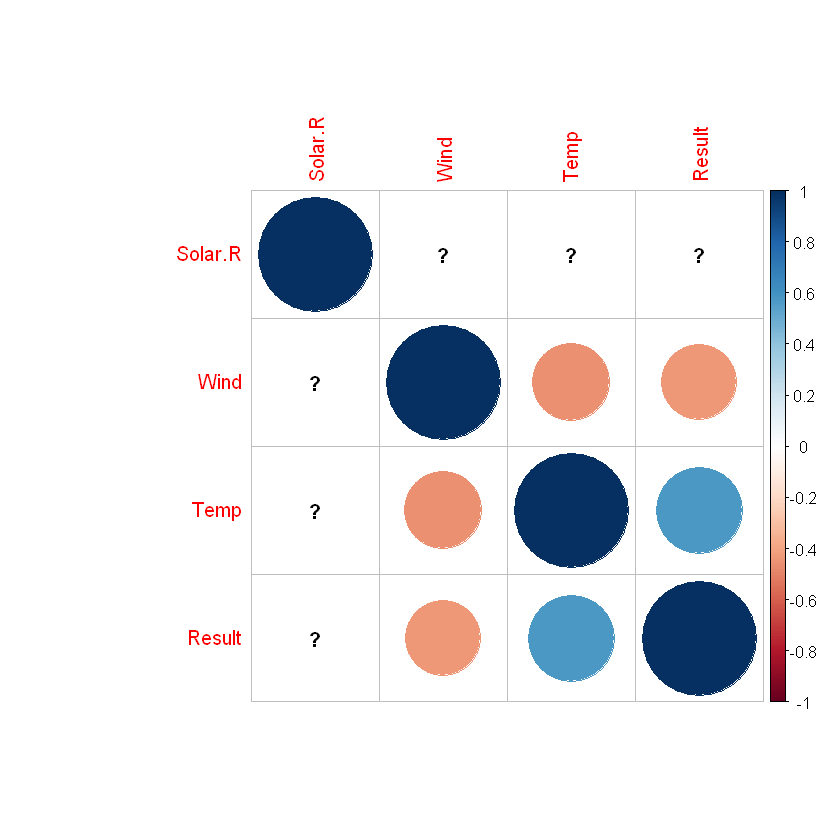

In [10]:
library(corrplot)
corrplot(cor(df), method='circle')


  0   1 
109  44 

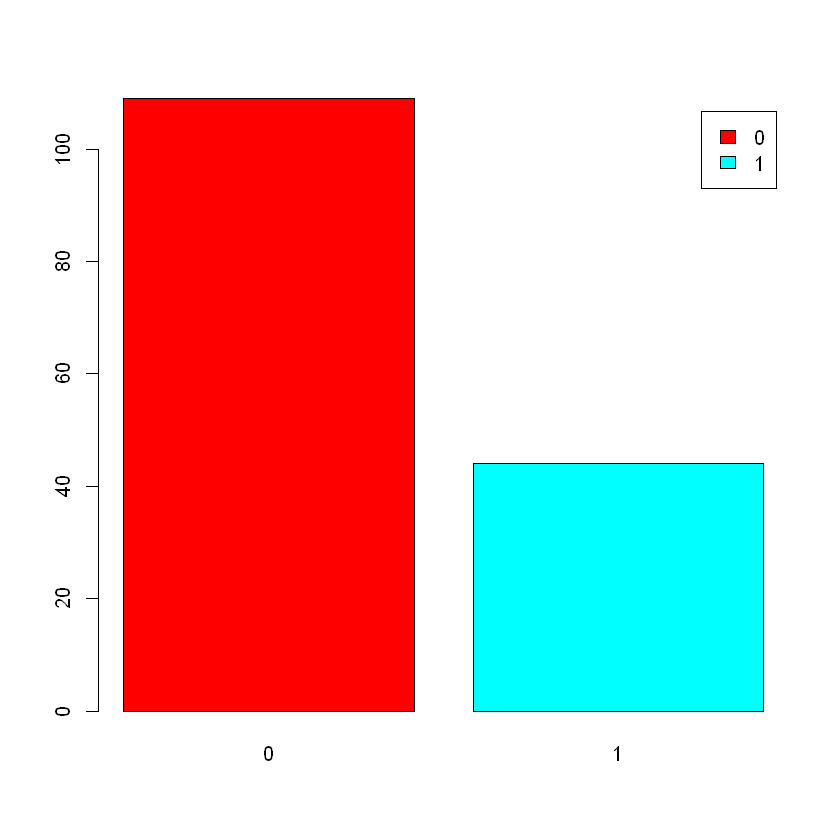

In [11]:
tbl<-table(df$Result) #Result 필드 카운트
tbl
barplot(tbl, beside=TRUE, legend=TRUE, col=rainbow(2))

In [12]:
install.packages('ROSE')

Installing package into 'C:/Users/tjoeun302-18/Documents/R/win-library/3.6'
(as 'lib' is unspecified)


package 'ROSE' successfully unpacked and MD5 sums checked

The downloaded binary packages are in
	C:\Users\tjoeun302-18\AppData\Local\Temp\Rtmpa409K2\downloaded_packages


In [16]:
library(ROSE)
df_samp<-ovun.sample(Result ~ . ,data=df, seed=1, method='under',
                    N=42*2)$data #p=0.5
tbl<-table(df_samp$Result)
tbl
#df_samp


 0  1 
42 42 

In [20]:
library(caret)
set.seed(123) #랜덤시드고정
# y종속변수, p 학습용 데이터셋의 비율, list=F 리스트를 반환하지 않음
idx_train<-createDataPartition(y=df_samp$Result,p=0.8,list=FALSE)
#idx_train
#학습용 데이터셋 선택
train<-df_samp[idx_train,]
X_train<-train[,-4] #독립변수(4번 필드 제외)
y_train<-train[,4] #종속변수(4번 필드)
#검증용데이터셋 선택
test<-df_samp[-idx_train,]
X_test<-test[,-4]
y_test<-test[,4]
head(X_train)
head(y_train)

,Solar.R,Wind,Temp
3,190,7.4,67
4,323,11.5,87
5,259,15.5,76
7,307,12.0,66
8,92,15.5,84
9,264,14.3,73


[1] 0 0 0 0 0 0

In [21]:
#로지스틱 회귀분석 모형, 학습용 데이터셋을 입력 binomial 2분류 ,glm: 2class 일 때 사용
model<-glm(Result ~ . , data=train, family = binomial)
summary(model)


Call:
glm(formula = Result ~ ., family = binomial, data = train)

Deviance Residuals: 
     Min        1Q    Median        3Q       Max  
-2.13095  -0.57184   0.05447   0.62744   1.89999  

Coefficients:
              Estimate Std. Error z value Pr(>|z|)   
(Intercept) -13.521560   5.708433  -2.369  0.01785 * 
Solar.R       0.004530   0.004979   0.910  0.36285   
Wind         -0.309449   0.133393  -2.320  0.02035 * 
Temp          0.190591   0.067695   2.815  0.00487 **
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 94.268  on 67  degrees of freedom
Residual deviance: 54.238  on 64  degrees of freedom
AIC: 62.238

Number of Fisher Scoring iterations: 6


In [22]:
(coef1<-coef(model)) #회귀계수 확인
#풍량이 증가하면 오존량이 감소
#온도가 올라가면 오존량 증가

(Intercept)       Solar.R          Wind          Temp 
-13.521559854   0.004530417  -0.309449104   0.190591329

In [27]:
#newdata 검증용데이터셋, 예측값이 0~1 사이로 출력됨
pred<-predict(model,newdata=X_test,type='response')
#pred
#0.5보다 크면 1, 아니면 0
result<-ifelse(pred>0.5,1,0)
#result

1  2  6 13 20 29 35 41 45 46 52 56 59 64 78 81 
 1  0  0  1  0  0  0  0  1  1  1  1  0  1  1  1

In [28]:
y_test == result

1     2     6    13    20    29    35    41    45    46    52    56    59 
FALSE  TRUE  TRUE FALSE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE FALSE 
   64    78    81 
 TRUE  TRUE  TRUE

In [24]:
mean(y_test==result) #예측정확도

[1] 0.8125

In [25]:
table(y_test,result) #오분류표(confusion matrix, 혼동행렬)
                     #81% 정확도

      result
y_test 0 1
     0 6 2
     1 1 7